## Installs and imports

In [94]:
!pip install pyscf qiskit-nature qiskit-algorithms qiskit-nature-pyscf

  Using cached qiskit_nature_pyscf-0.4.0-py3-none-any.whl.metadata (4.4 kB)
Using cached qiskit_nature_pyscf-0.4.0-py3-none-any.whl (15 kB)


In [98]:
from pyscf import gto, scf, ao2mo
import numpy as np
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.drivers import PySCFDriver
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from qiskit_aer import Aer
from qiskit_algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.primitives import Estimator
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_algorithms.optimizers import SPSA
from qiskit_nature.second_q.algorithms import QEOM, GroundStateSolver
from IPython.display import Image
from qiskit_algorithms import VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.problems import BaseProblem

In [27]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Finding ground state of a system

In [5]:
def expand_to_spin_orbital_basis(h1_ao, eri_ao):
    n = h1_ao.shape[0]
    h1_spin = np.kron(h1_ao, np.eye(2))
    eri_spin = np.zeros((2*n, 2*n, 2*n, 2*n))
    for p in range(2*n):
        for q in range(2*n):
            for r in range(2*n):
                for s in range(2*n):
                    eri_spin[p, q, r, s] = eri_ao[p//2, q//2, r//2, s//2] * (
                        (p % 2 == r % 2) and (q % 2 == s % 2)
                    )
    return h1_spin, eri_spin

In [140]:
def get_fermionic_op(atom_string: str, spin: int, charge: int, basis: str = "sto-3g"):
    driver = PySCFDriver(
        atom=atom_string,
        basis=basis,
        charge=charge,
        spin=spin,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()

    # Convert to FermionicOp
    atom_hamiltonian = problem.second_q_ops()

    return atom_hamiltonian[0]

In [135]:
def simulate_fermionic_op(atom_hamiltonian: FermionicOp, ansatz_reps: int = 2):
    # Convert to qubit Hamiltonian using Jordan-Wigner transformation
    mapper   = JordanWignerMapper()
    qubit_op = mapper.map(atom_hamiltonian)
    
    # Define the quantum ansatz
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=ansatz_reps)
    
    backend   = Aer.get_backend('statevector_simulator')
    estimator = Estimator()
    optimizer = SPSA()  # Create an instance of the optimizer
    vqe       = VQE(estimator, ansatz, optimizer)  # Pass the optimizer to VQE
    result    = vqe.compute_minimum_eigenvalue(qubit_op)

    optimized_ansatz = ansatz.assign_parameters(result.optimal_point)
    
    return result.eigenvalue.real, optimized_ansatz

In [163]:
StringLi2S = "Li 0.25 0.25 0.25; Li 0.75 0.75 0.75; S 0 0 0"

StringH2 = "H 0 0 0; H 0 0 0.735"

mol_op = get_fermionic_op(
    atom_string = StringH2,
    spin        = 0,
    charge      = 0
)

print("Built operator, running VQE...")

mol_ground_state, mol_optimal_ansatz = simulate_fermionic_op(mol_op, 4)

print("Hartree groundstate energy: ", mol_ground_state)

Built operator, running VQE...
Hartree groundstate energy:  -1.7948348154523173


In [145]:
mol_optimal_ansatz.decompose().draw()

┌────────────┐            ┌────────────┐                                »
q_0: ─┤ Ry(-3.257) ├─■──■─────■─┤ Ry(3.2382) ├─────────────────────■────────■─»
     ┌┴────────────┤ │  │     │ └────────────┘┌────────────┐       │        │ »
q_1: ┤ Ry(-3.1686) ├─■──┼──■──┼───────■───────┤ Ry(6.2124) ├───────■────────┼─»
     ├─────────────┤    │  │  │       │       └────────────┘┌─────────────┐ │ »
q_2: ┤ Ry(-3.5712) ├────■──■──┼───────┼─────────────■───────┤ Ry(-6.5712) ├─■─»
     └┬────────────┤          │       │             │       ├─────────────┤   »
q_3: ─┤ Ry(1.3656) ├──────────■───────■─────────────■───────┤ Ry(-9.1865) ├───»
      └────────────┘                                        └─────────────┘   »
«           ┌─────────────┐                                     ┌─────────────┐»
«q_0: ────■─┤ Ry(-3.0352) ├────────────────────■────────■─────■─┤ Ry(0.20365) ├»
«         │ └─────────────┘┌────────────┐      │        │     │ └─────────────┘»
«q_1: ─■──┼────────■───────┤ Ry(3.3136) ├──────■────────┼──■──┼────────■───────»
«      │  │        │       └────────────┘┌────────────┐ │  │  │        │       »
«q_2: ─■──┼────────┼─────────────■───────┤ Ry(3.8959) ├─■──■──┼────────┼───────»
«         │        │             │       ├────────────┤       │        │       »
«q_3: ────■────────■─────────────■───────┤ Ry(1.5617) ├───────■────────■───────»
«                                        └────────────┘                        »
«                                  
«q_0: ─────────────────────────────
«     ┌─────────────┐              
«q_1: ┤ Ry(-6.4228) ├──────────────
«     └─────────────┘┌────────────┐
«q_2: ───────■───────┤ Ry(2.8745) ├
«            │       ├────────────┤
«q_3: ───────■───────┤ Ry(3.5823) ├
«                    └────────────┘

## Finding higher energy eigenstates

Relevant reference: https://arxiv.org/abs/1910.12890

In [148]:
from qiskit_nature.second_q.problems import ElectronicStructureProblem

def get_higher_energy_states(atom_string: str, spin: int, charge: int, basis: str = "sto-3g", ansatz_reps: int = 2):
    backend   = Aer.get_backend('statevector_simulator')
    estimator = Estimator()
    mapper    = JordanWignerMapper()

    driver = PySCFDriver(
        atom=atom_string,
        basis=basis,
        charge=charge,
        spin=spin,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()

    optimizer  = SPSA()
    ansatz     = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=ansatz_reps)
    vqe_solver = VQE(estimator, ansatz, optimizer)
    
    ground_state_solver = GroundStateEigensolver(mapper, vqe_solver)
    
    qeom_solver = QEOM(
        ground_state_solver=ground_state_solver,
        estimator=estimator,
        excitations="sd"
    )
    qeom_result = qeom_solver.solve(problem)

    return qeom_result.groundenergy, qeom_result.total_energies

In [ ]:
h2_ground_energy, h2_higher_energies = get_higher_energy_states(
    atom_string = StringH2,
    spin        = 0,
    charge      = 0, 
    ansatz_reps = 7
)
print("H2: ", h2_ground_energy, h2_higher_energies)

li2s_ground_energy, li2s_higher_energies = get_higher_energy_states(
    atom_string = StringLi2S,
    spin        = 0,
    charge      = 0, 
    ansatz_reps = 7
)
print("Li2S: ", li2s_ground_energy, li2s_higher_energies)

H2:  -1.7903306845245301 [-1.07036169 -0.48805147 -0.12304971  0.54396717]


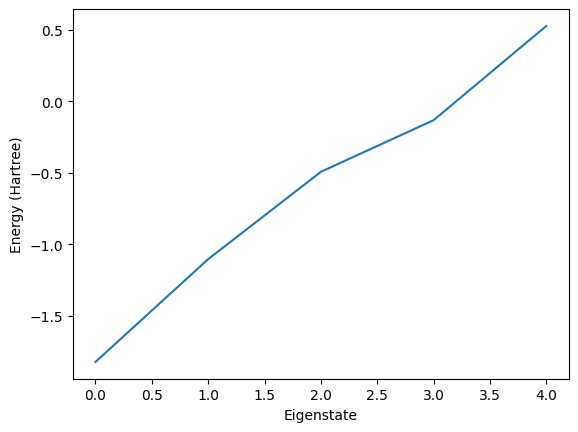

In [206]:
energies = [ground_energy] + list(higher_energies)
plt.plot(energies)
plt.ylabel("Energy (Hartree)")
plt.xlabel("Eigenstate")
plt.show()

## Compute variables of interest

In [237]:
import numpy as np

temperature = 300 # in Kelvin
beta        = 1 / (0.08617333262 * temperature) # meV

ground_energy  = energies[0]
delta_energies = [E - ground_energy for E in energies]

# Partition function
# Z = sum(np.exp(-beta * e * 27211.4) for e in delta_energies) # Hartree to meV
Z = sum(np.exp(-beta * e) for e in delta_energies) # not converting to make sure we have something to look at

# Free energy
F = -1/beta * np.log(Z)

print(f"Approximate Free Energy at 300K: {F:.6f}")

Approximate Free Energy at 300K: -40.400092


In [254]:
def partition_function(energies, temperature):
    # Z = sum(np.exp(-beta * e * 27211.4) for e in delta_energies) # Hartree to meV
    Z = sum(np.exp(-beta * e) for e in delta_energies) # not converting to make sure we have something to look at
    return Z

In [255]:
def free_energy(Z, temperature):
    beta = 1 / (0.08617333262 * temperature) # meV
    F = -1/beta * np.log(Z)
    return F

In [264]:
def heat_capacity(energies, partition_function, temperature):
    energies = np.array(energies)
    
    beta              = 1 / (0.08617333262 * temperature) # meV
    boltzmann_factors = np.exp(-beta * energies)
    probabilities     = boltzmann_factors / partition_function

    U  = np.sum(probabilities * energies)
    U2 = np.sum(probabilities * energies**2)

    Cv = beta**2 * (U2 - U**2)

    return Cv

In [266]:
temperatures    = np.linspace(10, 500, num=500)
free_energies   = []
heat_capacities = []

for temp in temperatures:
    Z = partition_function(delta_energies, temp)
    free_energies.append(free_energy(Z, temp))
    heat_capacities.append(heat_capacity(delta_energies, Z, temp)) 

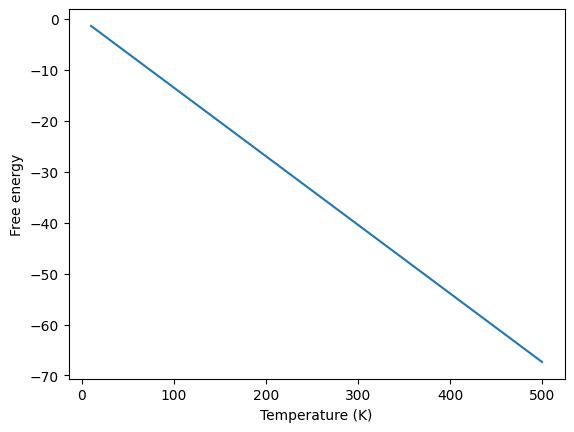

In [267]:
plt.plot(temperatures, free_energies)
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy")
plt.show()

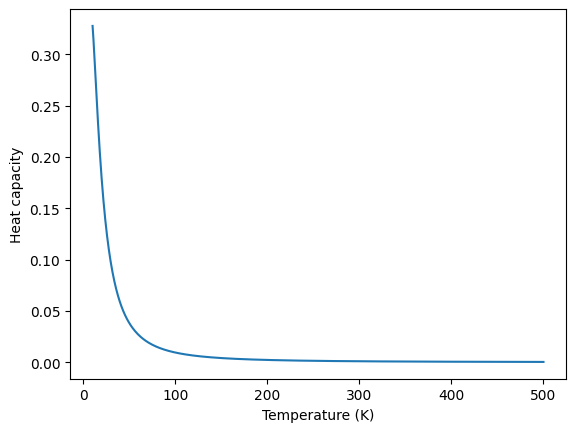

In [269]:
plt.plot(temperatures, heat_capacities)
plt.xlabel("Temperature (K)")
plt.ylabel("Heat capacity")
plt.show()